In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [3]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [4]:
from datasets import load_dataset

In [6]:
import pickle

In [7]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [8]:
with open('../../data/indices/5000-0.5/idx-val.pkl', 'rb')  as handle:
    idx_val = pickle.load(handle)
len(idx_val)

1000

In [9]:
import pandas as pd
df = pd.read_csv('../../../../codes/celeba/data/celeba/list_eval_partition.txt', delimiter=" ", 
                 names=['path', 'split'],
                 header=None, skipinitialspace=True)
df['path'] = df.apply(lambda x: "../../../../codes/celeba/data/celeba/img_align_celeba/{}".format(x['path']), axis=1)
df.head()    

,path,split
0,../../../../codes/celeba/data/celeba/img_align...,0
1,../../../../codes/celeba/data/celeba/img_align...,0
2,../../../../codes/celeba/data/celeba/img_align...,0
3,../../../../codes/celeba/data/celeba/img_align...,0
4,../../../../codes/celeba/data/celeba/img_align...,0


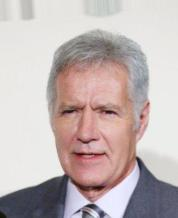

In [10]:
from datasets import Dataset, load_dataset, Image

train_dataset = Dataset.from_dict({"img": df.loc[idx_train]['path'].tolist(),
                                  }).cast_column("img", Image())
train_dataset[0]["img"]

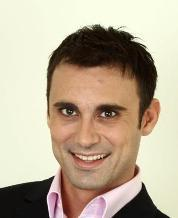

In [11]:
val_dataset = Dataset.from_dict({"img": df.loc[idx_val]['path'].tolist(),
                                  }).cast_column("img", Image())
val_dataset[0]["img"]

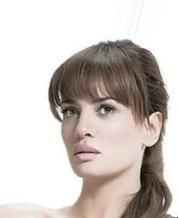

In [12]:
val_dataset[1]['img']

In [13]:
# idx_val[0:5]

In [14]:
# class Args():
            
#     dataset_name="cifar10"

#     # output_dir="./saved/1000-0.5/ddpm"
#     output_dir="../../saved/5000-0.5/ddpm/checkpoint-8000"
    
#     K=10
#     # project_dim=3584
#     Z=65536

#     # used_dim=4096
#     # used_dim=16384
#     used_dim=32768
    
#     t_strategy='cumulative'
    
#     # f='mean_squared_l2_norm'
#     # f='l2_norm'
#     # f='loss'
   
# args = Args()

In [15]:
# import diffusers
# from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
# from diffusers.optimization import get_scheduler

In [16]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1e3, eps=0.15)

2728

In [17]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=2e3, eps=0.15)

3002

In [18]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=5e3, eps=0.15)

3364

In [19]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1e4, eps=0.15)

3638

In [20]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [21]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-val.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

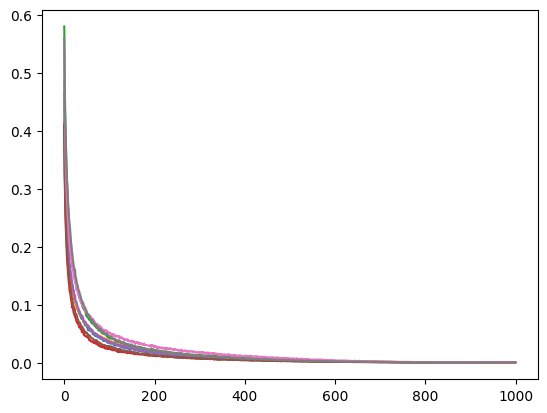

In [22]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [23]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [24]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

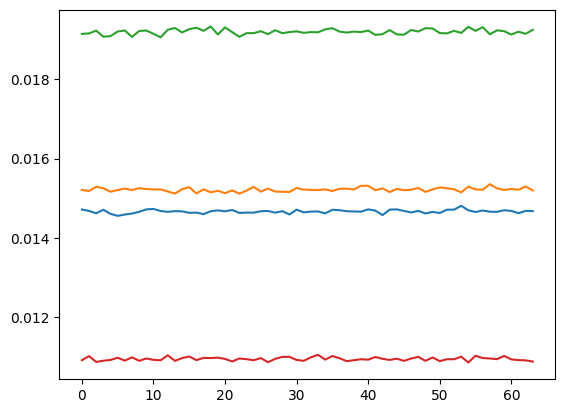

In [25]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [26]:
loss_array_list = []

for i in range(512):
    for seed in [
        0,
                 # 1,
                 # 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/retrain/ddpm-sub-{}-{}/e-{}-val.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3)
    
    loss_array_list.append(loss_array)
retrain_loss_array = np.stack(loss_array_list)
retrain_loss_array.shape

(512, 1000, 1000)

In [27]:
mask_array_list = []

for i in range(512):
    # print(i)
    with open('../../data/indices/5000-0.5/retrain/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
retrain_mask_array = np.stack(mask_array_list)
retrain_mask_array.shape

(512, 5000)

In [28]:
retrain_testset_correctness = retrain_loss_array.mean(axis=1)
retrain_testset_correctness.shape

(512, 1000)

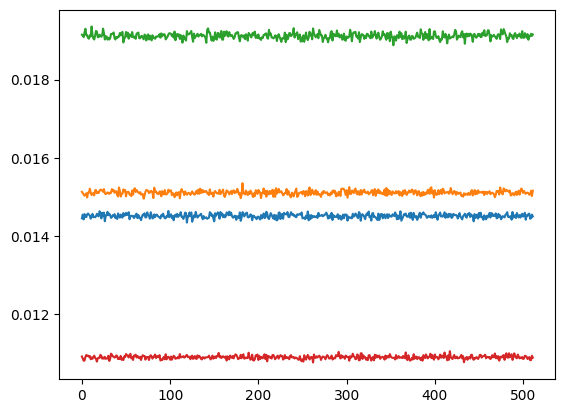

In [29]:
for j in range(4):
    plt.plot(retrain_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [30]:
# compute emp inf
def _masked_dot(x, mask, esp=1e-10):
    x = x.T
    return (np.matmul(x, mask) / np.maximum(np.sum(mask, axis=0, keepdims=True), esp))

In [31]:
scores = _masked_dot(retrain_testset_correctness, retrain_mask_array) - _masked_dot(retrain_testset_correctness, ~retrain_mask_array)
scores.shape

(1000, 5000)

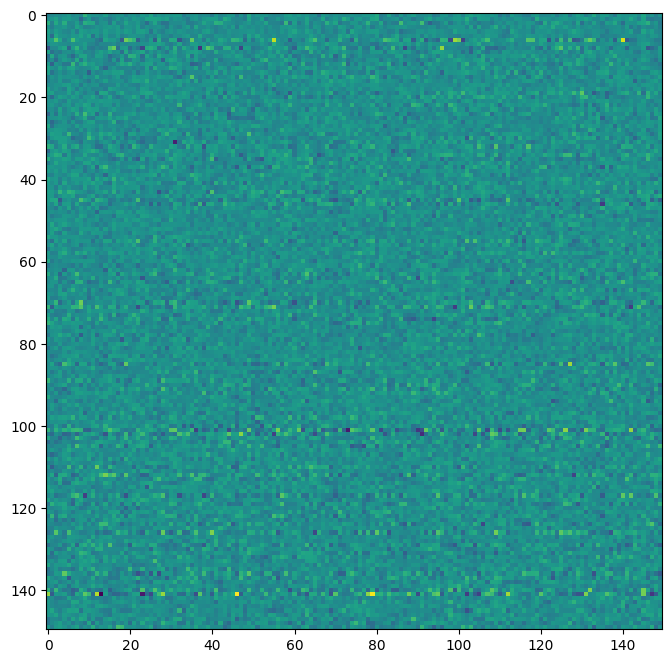

In [32]:
plt.figure(figsize = (8, 8))
plt.imshow(scores[0:150, 0:150], 
           # cmap='coolwarm',
          )

In [33]:
i = 2
D = scores[i]
D.shape

(5000,)

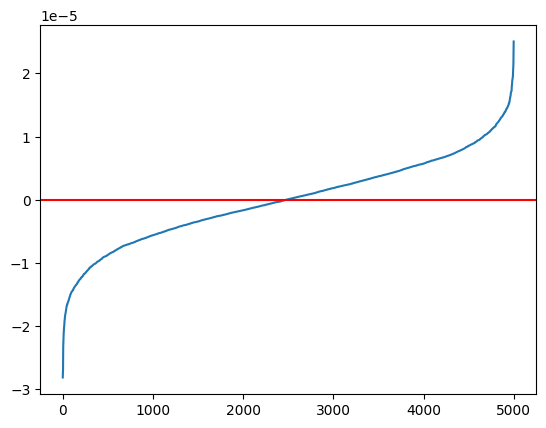

In [34]:
plt.plot(sorted(D))
plt.axhline(y=0, c='red')

In [35]:
topK = np.arange(10000)[D.argsort()[0:5]]
topK

array([3645, 2671,  589,  173, 4903])

In [36]:
plot_images = []
plot_images.append(val_dataset[i]['img'])
for idx in topK:
    plot_images.append(train_dataset[int(idx)]['img'])

In [37]:
val_artist = ''
val_artist

''

In [38]:
train_artist = []
for i in topK:
    tmp_artist = ''
    train_artist.append(tmp_artist)
train_artist   

['', '', '', '', '']

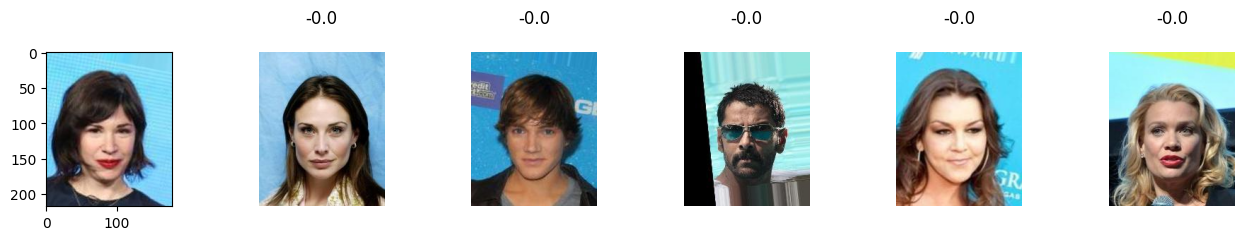

In [39]:
show_images(plot_images, D[D.argsort()[0:5]], val_artist, train_artist)

In [40]:
emp_scores_list = []

In [41]:
scores = _masked_dot(retrain_testset_correctness[0:64], retrain_mask_array[0:64]) - _masked_dot(retrain_testset_correctness[0:64], 
                                                                                                ~retrain_mask_array[0:64])
emp_scores_list.append(scores)

scores.shape

(1000, 5000)

In [42]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = scores
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

Correlation: 0.06501817319595386 (avg p value 0.472994)
Correlation: 0.065 (avg p value 0.472994)
Correlation: 0.0650 (avg p value 0.472994)
Correlation: 0.06502 (avg p value 0.472994)


In [43]:
scores = _masked_dot(retrain_testset_correctness[0:128], retrain_mask_array[0:128]) - _masked_dot(retrain_testset_correctness[0:128], 
                                                                                                ~retrain_mask_array[0:128])
emp_scores_list.append(scores)

scores.shape

(1000, 5000)

In [44]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = scores
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

Correlation: 0.08285310990841788 (avg p value 0.427809)
Correlation: 0.083 (avg p value 0.427809)
Correlation: 0.0829 (avg p value 0.427809)
Correlation: 0.08285 (avg p value 0.427809)


In [45]:
# scores = _masked_dot(retrain_testset_correctness[0:192], retrain_mask_array[0:192]) - _masked_dot(retrain_testset_correctness[0:192], 
#                                                                                                 ~retrain_mask_array[0:192])
# scores.shape

In [46]:
# # compute lds
# from scipy.stats import spearmanr, pearsonr
# ####
# margins = lds_testset_correctness
# infl_est_ = scores
# # infl_est_ = -tmp
# preds = lds_mask_array @ infl_est_.T
# ####
# rs = []
# ps = []

# for ind in range(1000):
#     r, p = spearmanr(preds[:, ind], margins[:, ind])
#     # r, p = pearsonr(preds[:, ind], margins[:, ind])
#     rs.append(r)
#     ps.append(p)
    
# rs, ps = np.array(rs), np.array(ps)
# print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
# print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
# print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
# print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

In [47]:
scores = _masked_dot(retrain_testset_correctness[0:256], retrain_mask_array[0:256]) - _masked_dot(retrain_testset_correctness[0:256], 
                                                                                                ~retrain_mask_array[0:256])
emp_scores_list.append(scores)

scores.shape

(1000, 5000)

In [48]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = scores
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

Correlation: 0.11172592034979706 (avg p value 0.389353)
Correlation: 0.112 (avg p value 0.389353)
Correlation: 0.1117 (avg p value 0.389353)
Correlation: 0.11173 (avg p value 0.389353)


In [49]:
scores = _masked_dot(retrain_testset_correctness[0:512], retrain_mask_array[0:512]) - _masked_dot(retrain_testset_correctness[0:512], 
                                                                                                ~retrain_mask_array[0:512])
emp_scores_list.append(scores)

scores.shape

(1000, 5000)

In [50]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = scores
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

Correlation: 0.15650844248433587 (avg p value 0.316604)
Correlation: 0.157 (avg p value 0.316604)
Correlation: 0.1565 (avg p value 0.316604)
Correlation: 0.15651 (avg p value 0.316604)


In [51]:
my_data = {
    'margins': margins[:, 0],
    'preds': preds[:, 0]
}

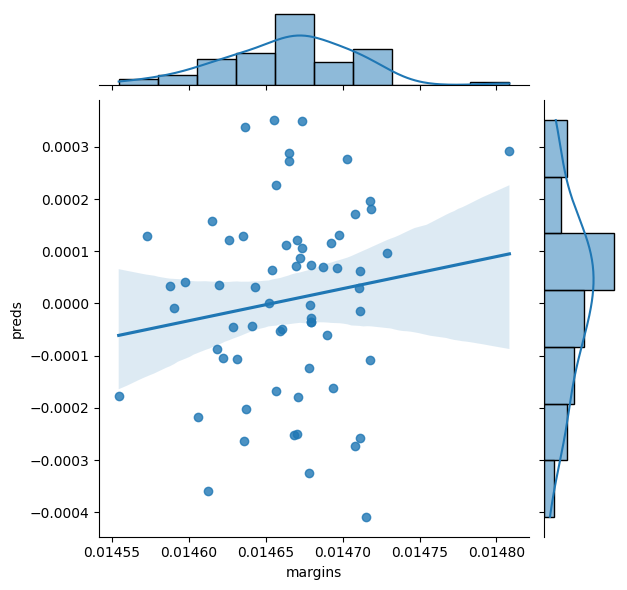

In [52]:
import seaborn as sns
sns.jointplot(data=my_data, x="margins", y="preds", kind="reg")

In [53]:
len(emp_scores_list)

4

In [54]:
with open('./val_emp.pkl', 'wb') as handle:
    pickle.dump(emp_scores_list, handle)